In [80]:
import numpy as np
import cv2 as cv
import heapq
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx

In [81]:
class HuffmanNode:
    def __init__(self, freq, symbol=None, left=None, right=None):
        self.freq = freq
        self.symbol = symbol
        self.left = left
        self.right = right
        self.huff = ''
    
    def __lt__(self, other):
        return self.freq < other.freq

In [82]:
def calculate_frequency(data):
    # Menghitung frekuensi kemunculan setiap nilai pixel
    freq_dict = defaultdict(int)
    for value in data:
        freq_dict[value] += 1
    return freq_dict

In [83]:
def build_huffman_tree(freq_dict):
    # Membangun pohon Huffman
    heap = []
    for symbol, freq in freq_dict.items():
        heapq.heappush(heap, HuffmanNode(freq, symbol))
    
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        internal = HuffmanNode(left.freq + right.freq)
        internal.left = left
        internal.right = right
        heapq.heappush(heap, internal)

    return heap[0]

In [84]:
def generate_codes(root, code='', codes=None):
    # Menghasilkan kode Huffman untuk setiap simbol
    if codes is None:
        codes = {}
    
    if root.symbol is not None:
        codes[root.symbol] = code
    else:
        generate_codes(root.left, code + '0', codes)
        generate_codes(root.right, code + '1', codes)
        
    return codes

In [85]:
def compress_image(image_path):
    # Melakukan kompresi citra menggunakan kode Huffman
    img = cv.imread(image_path)

    # Proses untuk setiap channel (B, G, R)
    compressed_channels = []
    huffman_trees = []
    codes_per_channel = []

    for channel_idx in range(3):
        channel = img[:, :, channel_idx].flatten()

        # Hitung frekuensi
        freq_dict = calculate_frequency(channel)
        
        # Bangun pohon Huffman
        root = build_huffman_tree(freq_dict)
        huffman_trees.append(root)

        # Generate kode Huffman
        codes = generate_codes(root)
        codes_per_channel.append(codes)

        # Kompresi data
        compressed_data = ''.join([codes[pixel] for pixel in channel])
        compressed_channels.append(compressed_data)
    
    return compressed_channels, huffman_trees, codes_per_channel, img.shape

In [86]:
def decompress_image(compressed_channels, huffman_trees, original_shape):
    # Melakukan dekompresi citra
    decompress_channels = []

    for compressed_data, root in zip(compressed_channels, huffman_trees):
        # Dekompresi channel
        current = root
        decompressed = []

        for bit in compressed_data:
            if bit == '0':
                current = current.left
            else:
                current = current.right
            
            if current.symbol is not None:
                decompressed.append(current.symbol)
                current = root
        
        # Reshape channel
        decompress_channel = np.array(decompressed).reshape(original_shape[:2])
        decompress_channels.append(decompress_channel)
    
    # Gabungkan channels
    decompress_image = cv.merge(decompress_channels)
    return decompress_image

In [ ]:
def visualize_huffman_tree(root):
    # Memvisualisasikan pohon Huffman menggunakan networkx
    G = nx.Graph()
    pos = {}
    labels = {}
    def add_nodes(node, x=0, y=0, layer=1):
        if node is None:
            return
        
        # Buat ID unik untuk node
        node_id = id(node)

        # Tambahkan node ke graph
        if node.symbol is not None:
            G.add_node(node_id)
            labels[node_id] = f"{node.symbol}\n{node.freq}"
        else:
            G.add_node(node_id)
            labels[node_id] = str(node.freq)
        pos[node_id] = (x, y)

        # Recursively add children
        if node.left:
            left_id = id(node.left)
            G.add_edge(node_id, left_id)
            add_nodes(node.left, x-1/layer, y-1, layer+1)
        if node.right:
            right_id = id(node.right)
            G.add_edge(node_id, right_id)
            add_nodes(node.right, x+1/layer, y-1, layer+1)

    add_nodes(root)

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos=pos, labels=labels, with_labels=True, node_color='lightblue', node_size=2000, font_size=8, font_weight='bold')
    plt.title("Pohon Huffman")
    plt.show()

In [88]:
def main(image_path):
    # Kompresi
    compressed_channels, huffman_trees, codes, original_shape = compress_image(image_path)

    # Visualisasi pohon Huffman untuk channel pertama (Blue)
    print("Visualisasi Pohon HUffman untuk Channel Blue:")
    visualize_huffman_tree(huffman_trees[0])

    # Dekompresi
    decompressed_img = decompress_image(compressed_channels, huffman_trees, original_shape)

    # Tampilkan hasil
    plt.figure(figsize=(12, 4))

    plt.subplot(121)
    plt.imshow(cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB))
    plt.title("Gambar Asli")
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(cv.cvtColor(decompressed_img, cv.COLOR_BGR2RGB))
    plt.title("Gambar Hasil Dekompresi")
    plt.axis('off')

    plt.show()

    # Hitung dan tampilkan rasio kompresi
    original_size = cv.imread(image_path).nbytes
    compressed_size = sum(len(channel) for channel in compressed_channels) // 8
    compression_ratio = (1 - compressed_size/original_size) * 100

    print(f"\nUkuran file asli: {original_size/1024:.2f} KB")
    print(f"Ukuran file terkompresi: {compressed_size/1024:.2f} KB")
    print(f"Rasio kompresi: {compression_ratio:.2f}%")

Visualisasi Pohon HUffman untuk Channel Blue:


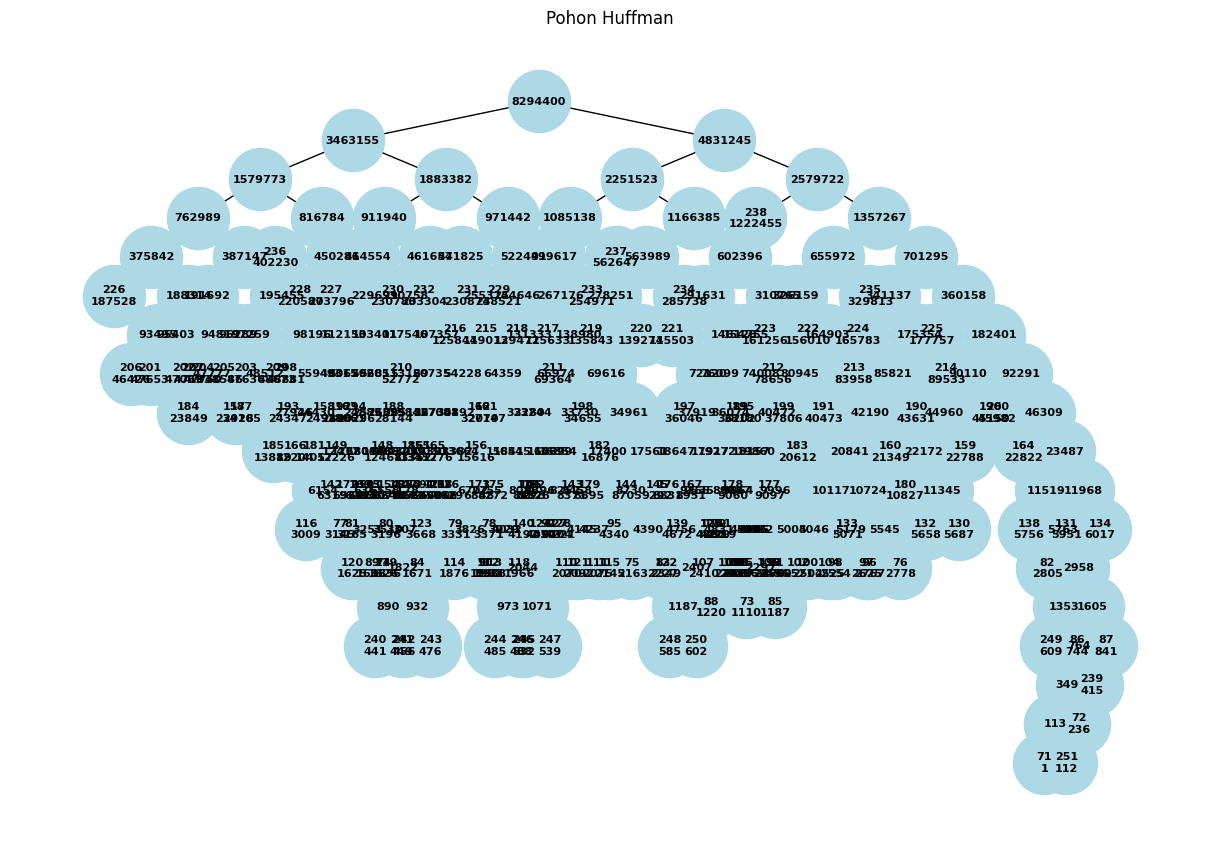

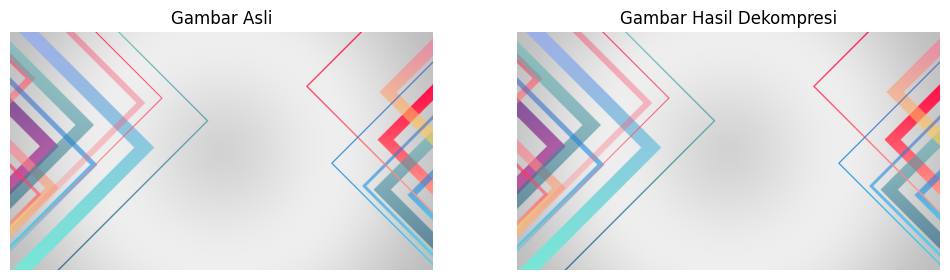


Ukuran file asli: 24300.00 KB
Ukuran file terkompresi: 17361.97 KB
Rasio kompresi: 28.55%


In [89]:
image_path = 'Gambar/Pertemuan 10/White-Color-Abstract-Background-4k-Download.png'

main(image_path)